# DTW-SOM Evaluation - experiment with the UWaveGesture dataset

## 1. Packadge import

In [28]:
import os
import csv
import math
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.nnet.som import type_conn
from matrixprofile import matrixProfile, motifs
# local code
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

## 2. Preprare the UWaveGesture dataset

Load the dataset:

In [2]:
ucr_data_folder = os.path.abspath("../../data-ucr-archive")
file = os.path.join(ucr_data_folder, "UWaveGestureLibraryX", "UWaveGestureLibraryX_TRAIN.tsv")
ts_data = []
ts_labels = []
with open(file) as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC)
    for line in tsvreader:
        ts_labels.append(line[0])
        ts_data.append(np.array(line[1:]))
size = len(ts_data[0])
classes = len(set(ts_labels))
print("Subquence size: "+str(size))
print("No of classes: "+str(classes))
print("Dataset size:: "+str(len(ts_labels)))

Subquence size: 315
No of classes: 8
Dataset size:: 896


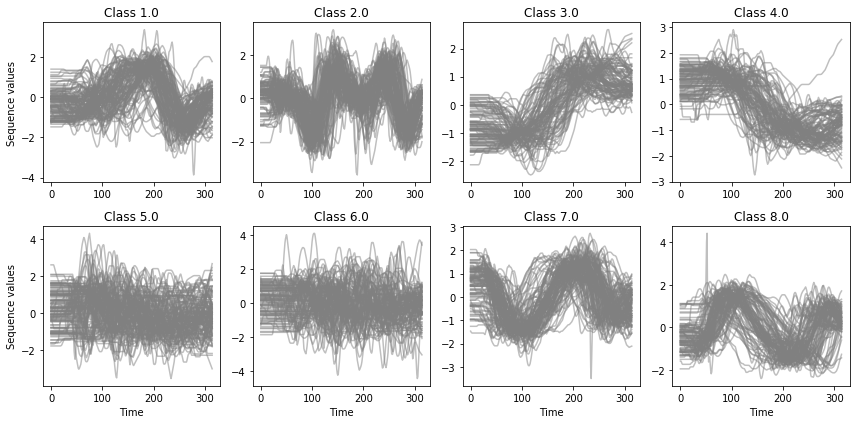

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(12,6))
for i in range(len(ts_labels)):
    label = ts_labels[i]-1
    col = int(label % 4)
    row = math.floor(label/4)
    axs[row, col].plot(np.arange(size), ts_data[i], alpha=0.5, color="grey")
    axs[row, col].set_title("Class "+str(label+1))
    if col==0:
        axs[row, col].set_ylabel("Sequence values")
    if row==1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

Now, let's exclude classes 5 and 6 and sample the rest of the dataset so that the run is quicker:

In [4]:
filter_ts_labels = []
filter_ts_data = []
for i in range(len(ts_labels)):
    if ts_labels[i] not in [5.0, 6.0]:
        filter_ts_data.append(ts_data[i])
        filter_ts_labels.append(ts_labels[i])
print(set(filter_ts_labels))
print(len(filter_ts_labels))

{1.0, 2.0, 3.0, 4.0, 7.0, 8.0}
658


In [5]:
sample_indexes = random.sample(range(len(filter_ts_data)), 400)
ts_data = [filter_ts_data[i] for i in sample_indexes]
ts_labels = [filter_ts_labels[i] for i in sample_indexes]

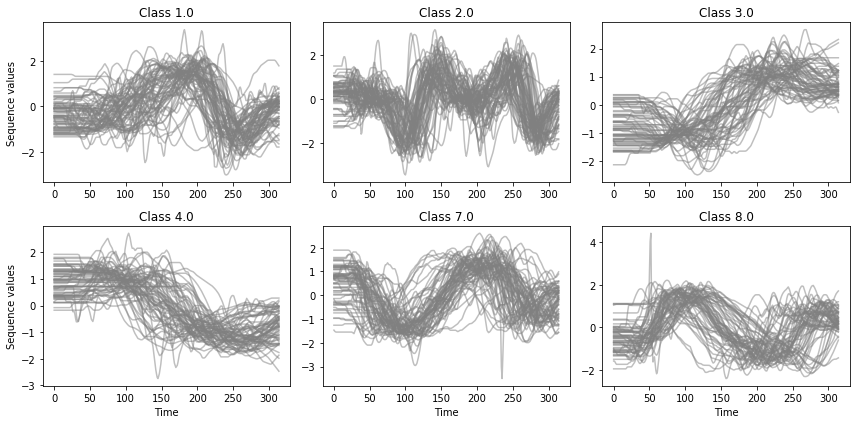

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12,6))
for i in range(len(ts_labels)):
    label = ts_labels[i]-1
    if label > 3:
        col = int((label-2) % 3)
        row = math.floor((label-2)/3)
    else:
        col = int(label % 3)
        row = math.floor(label/3)
    axs[row, col].plot(np.arange(size), ts_data[i], alpha=0.5, color="grey")
    axs[row, col].set_title("Class "+str(ts_labels[i]))
    if col==0:
        axs[row, col].set_ylabel("Sequence values")
    if row==1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

Convert it to a single time-series by concatenating each subsequence:

In [7]:
joined_ts_data = ts_data[0]
joined_ts_labels = [ts_labels[0]]*size
for i in range(1, len(ts_labels)):
    joined_ts_data = np.concatenate((joined_ts_data, ts_data[i]))
    joined_ts_labels = joined_ts_labels + [ts_labels[i]]*size
len(joined_ts_data)

126000

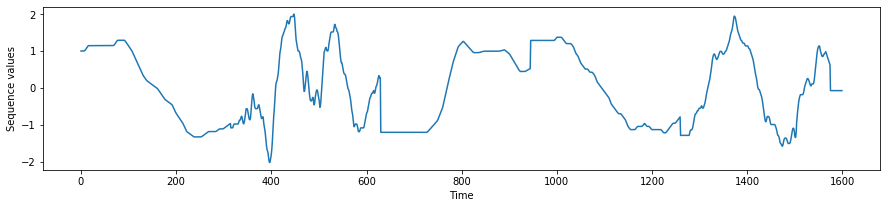

In [8]:
plt.figure(figsize=(15,3))
plt.plot(np.arange(1600), joined_ts_data[:1600])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

Compute the matrix profile with STOMP:

In [9]:
%%time
mp = matrixProfile.stomp(joined_ts_data, size)

CPU times: user 7min 2s, sys: 2.82 s, total: 7min 5s
Wall time: 7min 12s


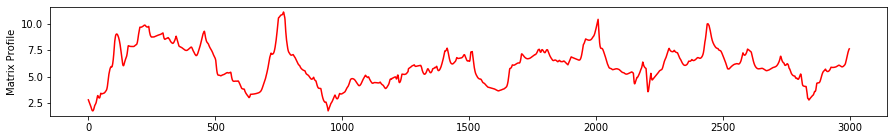

In [10]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(3000), mp_adj[:3000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extract all the motifs:

In [11]:
%%time
mtfs, motif_d  = motifs.motifs(joined_ts_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 2.04 s, sys: 11 ms, total: 2.05 s
Wall time: 2.05 s


120

Create list of motifs centers:

In [12]:
motif_center_list = []
motif_center_labels = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center_ts = joined_ts_data[center_pointers]
    motif_center_list.append(motif_center_ts)
    center_labels = [joined_ts_labels[i] for i in center_pointers]
    center_final_label = max(center_labels, key=center_labels.count)
    motif_center_labels.append(center_final_label)

## 3. Train DTW-SOM with random initialization and view results

Define the SOM network:

In [13]:
%time
n = 4
rows = n
cols = n
structure = type_conn.grid_four
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


Train the network:

In [14]:
%%time
network.train(motif_center_list, 20)

Epoch 1 achieved an average quantization error of 5.7368
Epoch 2 achieved an average quantization error of 6.165
Epoch 3 achieved an average quantization error of 6.3492
Epoch 4 achieved an average quantization error of inf
Epoch 5 achieved an average quantization error of 6.709
Epoch 6 achieved an average quantization error of 6.6035
Epoch 7 achieved an average quantization error of 6.5726
Epoch 8 achieved an average quantization error of 6.4268
Epoch 9 achieved an average quantization error of 6.3425
Epoch 10 achieved an average quantization error of 6.3614
Epoch 11 achieved an average quantization error of inf
Epoch 12 achieved an average quantization error of 6.2208
Epoch 13 achieved an average quantization error of 6.2322
Epoch 14 achieved an average quantization error of 6.046
Epoch 15 achieved an average quantization error of 5.8236
Epoch 16 achieved an average quantization error of 5.6539
Epoch 17 achieved an average quantization error of 5.5546
Epoch 18 achieved an average qua

20

Vizualise DTW-SOM U-matrix:

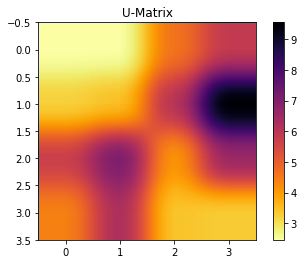

In [15]:
network.show_distance_matrix()

Vizualise the winner matrix:

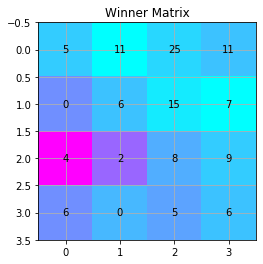

In [16]:
network.show_winner_matrix()

Vizualise the units' sequence values:

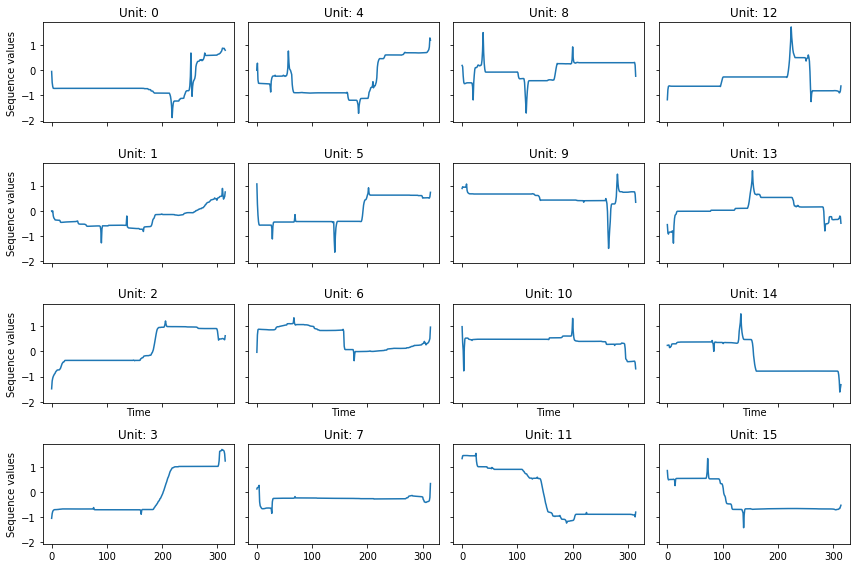

In [17]:
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(3*n, 2*n), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

## 4. Explore clusters

In [19]:
true_labels = []
predicted_labels = []
for cluster_list in network.capture_objects:
    if len(cluster_list)>0:
        cluster_true_labels = [motif_center_labels[i] for i in cluster_list]
        cluster_label = max(cluster_true_labels, key=cluster_true_labels.count)
        cluster_predicted_labels = [cluster_label]*len(cluster_true_labels)
        true_labels += cluster_true_labels
        predicted_labels += cluster_predicted_labels
accuracy = np.mean([i==j for i,j in zip(true_labels, predicted_labels)])
accuracy

0.48333333333333334

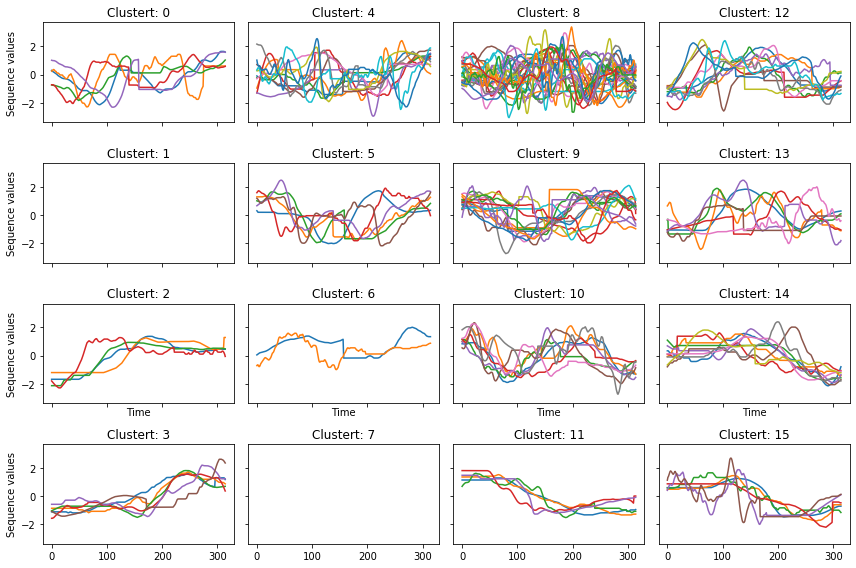

In [20]:
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(3*n, 2*n), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Clustert: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

#### Cluster 4:

In [21]:
len(network.capture_objects[4])

11

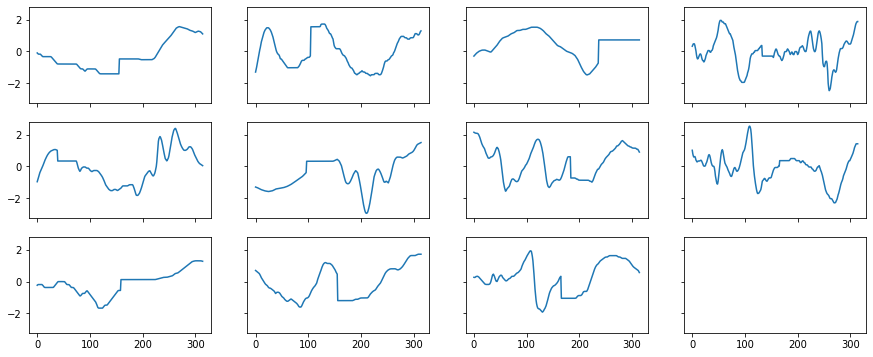

In [22]:
fig, axs = plt.subplots(3,4,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[4]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/3)
    row = i % 3
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

#### Cluster 8:

In [30]:
len(network.capture_objects[8])

25

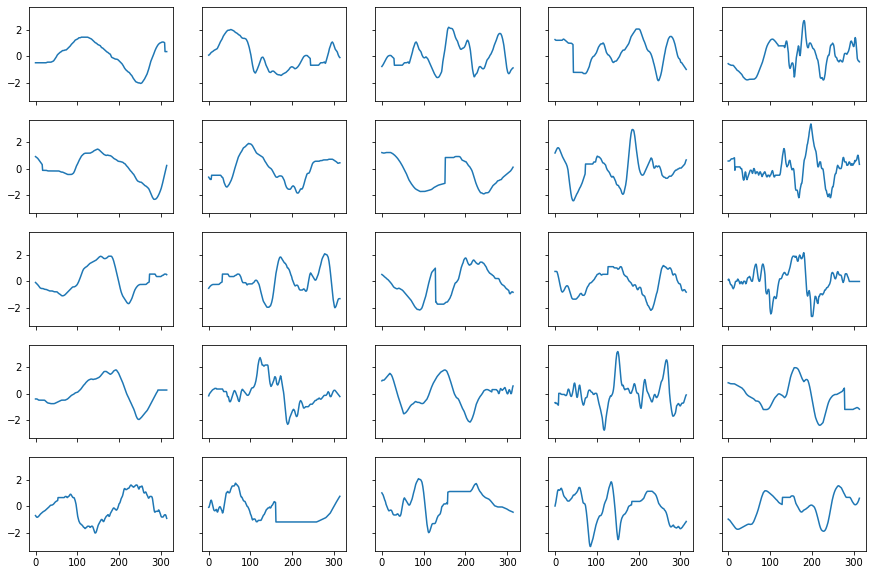

In [32]:
fig, axs = plt.subplots(5,5,figsize=(15, 10), sharex=True, sharey=True)
cluster_list = network.capture_objects[8]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/5)
    row = i % 5
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

#### Cluster 5:

In [23]:
len(network.capture_objects[5])

6

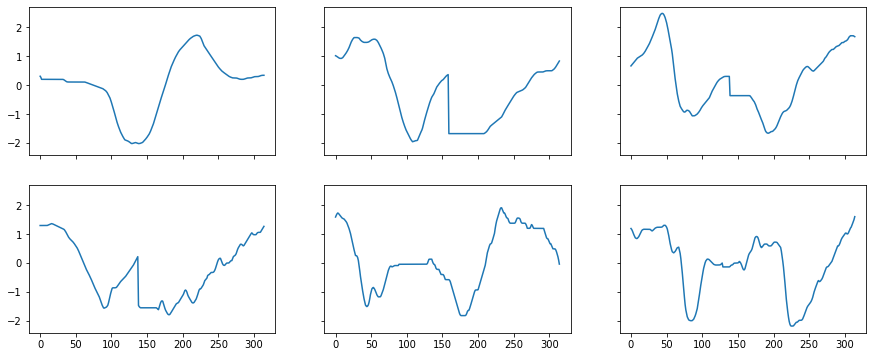

In [24]:
fig, axs = plt.subplots(2,3,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[5]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

#### Cluster 12:

In [33]:
len(network.capture_objects[12])

11

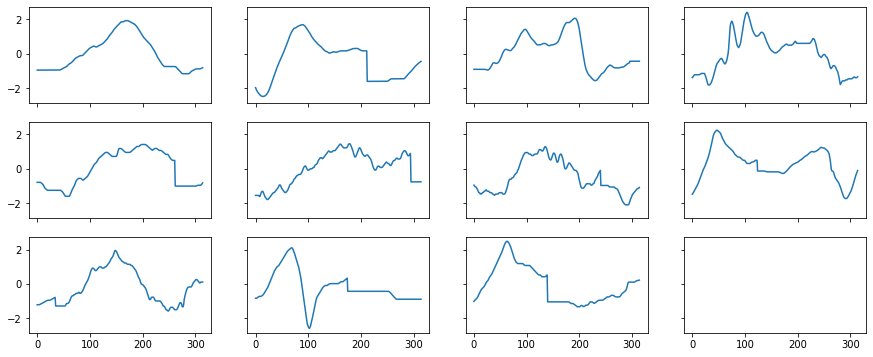

In [34]:
fig, axs = plt.subplots(3,4,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[12]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/3)
    row = i % 3
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

#### Cluster 13:

In [35]:
len(network.capture_objects[13])

7

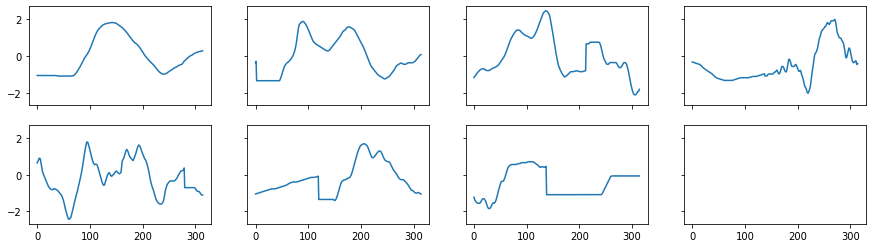

In [36]:
fig, axs = plt.subplots(2,4,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[13]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

## 5. Checkpoint results

In [29]:
pickle.dump(joined_ts_data, open("joined_ts_data.p", "wb"))
pickle.dump(motif_center_list, open("motif_center_list.p", "wb"))
pickle.dump(motif_center_labels, open("motif_center_labels.p", "wb"))
pickle.dump(mtfs, open("mtfs.p", "wb"))
pickle.dump(network, open("network.p", "wb"))